Copyright 2020 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [3]:
import collections
import glob
import functools
import itertools
import os
from typing import Callable, List, Mapping, Sequence, Tuple

from matplotlib import pyplot as plt
import model_util
import numpy as np
import pandas as pd
import pwlf
from pwlfit import fitter
from pwlfit import pwlcurve
from scipy import stats
from sklearn import metrics


plt.style.use('seaborn-ticks')
plt.rcParams.update({'font.size': 18})


def fit_pwlfit(xs: Sequence[float], ys: Sequence[float], 
               num_segments: int = 3, mono: bool = False):
    """Fits a PWLCurve using pwlfit."""
    return fitter.fit_pwl(xs, ys, num_segments=num_segments, mono=mono).round_to_sig_figs(4)


def fit_pwlf(xs: Sequence[float], ys: Sequence[float], 
             num_segments: int = 3, num_samples: int = 1000) -> pwlcurve.PWLCurve:
    """Fits a PWLCurve using pwlf."""
    mask = model_util.approx_sample(len(xs), num_samples)
    my_pwlf = pwlf.PiecewiseLinFit(xs[mask], ys[mask])
    knot_xs = my_pwlf.fit(num_segments, seed=5)
    knot_ys = my_pwlf.predict(knot_xs)
    return pwlcurve.PWLCurve(list(zip(knot_xs, knot_ys))).round_to_sig_figs(4)


def make_models_per_fold(cv_folds: Sequence[pd.DataFrame], 
                         continuous_targets: Mapping[str, str],
                         discrete_targets: Mapping[str, str]) -> List[List[model_util.Model]]:
    """Make list of models to analyze per cv fold."""
    models_per_fold = []
    for df in cv_folds:
        train_df = df[df.fold]
        models = [
            model_util.ColumnModel('interacting_trees'),
            model_util.ColumnModel('gam_trees')
        ]
        models += [model_util.ColumnModel('sgd_num_segments_%d' % i) 
                   for i in list(range(1, 11)) + [15, 20]]
        for (i, mono) in itertools.product(range(1, 6), (False, True)):
            curve_fitter = functools.partial(fit_pwlfit, num_segments=i, mono=mono)
            pwlfit_model, _ = model_util.fit_additive_model(
                df, continuous_targets, discrete_targets, curve_fitter,
                'pwlfit; num_segments=%d mono=%s' % (i, mono)
            )
            models.append(pwlfit_model)
        for i in range(2, 6):
            curve_fitter = functools.partial(fit_pwlf, num_segments=i)
            pwlf_model, _ = model_util.fit_additive_model(
                df, continuous_targets, discrete_targets, curve_fitter,
                'pwlf; num_segments=%d' % i
            )
            models.append(pwlf_model)
        models_per_fold.append(models)
    return models_per_fold


def make_cv_metric_df(
    cv_folds: Sequence[pd.DataFrame],
    models_per_fold: Sequence[Sequence[model_util.Model]],
    metric: Callable[[Sequence[float], Sequence[float]], float]) -> pd.DataFrame:
    """Computes cross validated metrics for given models."""
    metric_values = collections.defaultdict(list)
    for fold_df, fold_models in zip(cv_folds, models_per_fold):
        test_df = fold_df[np.logical_not(fold_df.fold)]
        for model in fold_models:
            metric_values[model.name].append(metric(test_df.label, model.eval(test_df)))
    metric_values = pd.DataFrame(metric_values)
    return metric_values


def read_data(input_dir: str):
    """Reads data and returns a list of one DataFrame per cv fold."""
    [attr_path] = glob.glob(os.path.join(input_dir, '*.attr'))
    with open(attr_path, 'r') as f:
        column_names = [line.split(':')[0] for line in f.readlines()]
    [data_path] = glob.glob(os.path.join(input_dir, '*.data'))
    root_df = pd.read_csv(data_path, names=column_names, header=None, delim_whitespace=True)
    root_df['label'] = root_df[column_names[-1]]
    cv_dfs = []
    for i in range(5):
        fold_df = pd.read_parquet(os.path.join(input_dir, 'fold_%d.parquet' % i))
        cv_dfs.append(pd.concat([root_df, fold_df], axis=1))
    return cv_dfs


def compute_ci_width(col):
    mean = np.mean(col)
    _, upper  = stats.t.interval(0.95, len(col) - 1, loc=mean, scale=stats.sem(col))
    return upper - mean

In [ ]:
INPUT_DIR = '<YOUR_INPUT_DIR>'

In [5]:
cv_folds = read_data(INPUT_DIR)
CONTINUOUS_FEATURES = [
    'NumRevolvingTradesWBalance', 'MSinceOldestTradeOpen', 'NumTotalTrades',
    'NumBank2NatlTradesWHighUtilization', 'PercentTradesWBalance',
    'PercentInstallTrades', 'MaxDelqEver', 'NumSatisfactoryTrades',
    'MSinceMostRecentTradeOpen', 'NetFractionInstallBurden',
    'PercentTradesNeverDelq', 'NumTradesOpeninLast12M',
    'NetFractionRevolvingBurden', 'MSinceMostRecentDelq',
    'NumInqLast6Mexcl7days', 'NumTrades60Ever2DerogPubRec', 'AverageMInFile',
    'MaxDelq2PublicRecLast12M', 'NumInqLast6M', 'NumInstallTradesWBalance',
    'MSinceMostRecentInqexcl7days', 'NumTrades90Ever2DerogPubRec'
]
CATEGORICAL_FEATURES = ['delinquent', 'inquiry']

In [ ]:
models_per_fold = make_models_per_fold(
    cv_folds,
    {name: 'gam_trees_%s' % name for name in CONTINUOUS_FEATURES},
    {name: 'gam_trees_%s' % name for name in CATEGORICAL_FEATURES}
)

In [7]:
rmse_df = make_cv_metric_df(cv_folds, models_per_fold, functools.partial(metrics.mean_squared_error, squared=False))
rmse_df

,interacting_trees,gam_trees,sgd_num_segments_1,sgd_num_segments_2,sgd_num_segments_3,sgd_num_segments_4,sgd_num_segments_5,sgd_num_segments_6,sgd_num_segments_7,sgd_num_segments_8,...,pwlfit; num_segments=3 mono=False,pwlfit; num_segments=3 mono=True,pwlfit; num_segments=4 mono=False,pwlfit; num_segments=4 mono=True,pwlfit; num_segments=5 mono=False,pwlfit; num_segments=5 mono=True,pwlf; num_segments=2,pwlf; num_segments=3,pwlf; num_segments=4,pwlf; num_segments=5
0,3.122789,3.514985,4.313388,4.008070,3.892398,3.785680,3.688109,3.656454,3.647385,3.642315,...,3.591978,3.745236,3.538079,3.752823,3.522920,3.752119,3.759702,3.629104,3.537710,3.556036
1,3.278046,3.676009,4.438151,4.179886,4.023405,3.912858,3.793797,3.730132,3.752979,3.713710,...,3.683506,3.836788,3.655861,3.836742,3.651820,3.846936,3.860417,3.716826,3.639759,3.651649
2,3.127420,3.455564,4.289045,3.934681,3.830541,3.657442,3.581540,3.496371,3.527423,3.464455,...,3.465679,3.591202,3.444663,3.587118,3.440738,3.595014,3.635565,3.502362,3.449491,3.448945
3,3.032307,3.402114,4.327871,3.970371,3.832526,3.705685,3.561996,3.501495,3.515926,3.487276,...,3.454002,3.618194,3.437559,3.622389,3.416304,3.631392,3.669446,3.472653,3.428017,3.527946
4,3.081533,3.427694,4.377940,4.048793,3.854943,3.647355,3.589843,3.529518,3.574178,3.495148,...,3.479833,3.656617,3.446041,3.650197,3.434434,3.651228,3.696481,3.519256,3.445279,3.438561


In [8]:
pd.concat([rmse_df.mean(), rmse_df.apply(compute_ci_width)], axis=1)

,0,1
interacting_trees,3.128419,0.114234
gam_trees,3.495273,0.135842
sgd_num_segments_1,4.349279,0.073705
sgd_num_segments_2,4.028360,0.117676
sgd_num_segments_3,3.886763,0.099755
sgd_num_segments_4,3.741804,0.136762
sgd_num_segments_5,3.643057,0.120925
sgd_num_segments_6,3.582794,0.130302
sgd_num_segments_7,3.603578,0.121953
sgd_num_segments_8,3.560581,0.137461


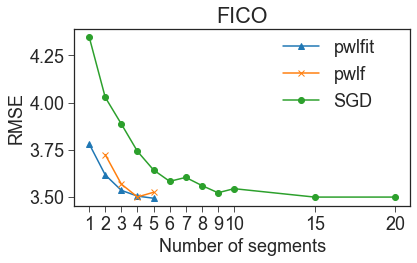

In [9]:
mean = rmse_df.mean()
index_str = mean.index.str
num_segments = mean.index.str.extract(r'num_segments(?:=|_)(\d+)', expand=False)

plt.plot(num_segments[index_str.match(r'pwlfit;.*mono=False')].astype(int), 
         mean[index_str.match(r'pwlfit;.*mono=False')], marker='^', label='pwlfit')
plt.plot(num_segments[index_str.match('pwlf;')].astype(int), 
         mean[index_str.match('pwlf;')], marker='x', label='pwlf')
plt.plot(num_segments[index_str.match('sgd_')].astype(int), 
         mean[index_str.match('sgd_')], marker='o', label='SGD')
plt.gca().set_xticks(num_segments.dropna().drop_duplicates().astype(int))
plt.gca().set_xlabel('Number of segments')
plt.gca().set_ylabel('RMSE')
plt.title('FICO')
plt.legend(loc=(0.6, 0.5))
plt.tight_layout()

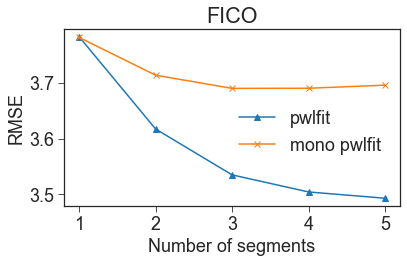

In [10]:
mean = rmse_df.mean()
num_segments = mean.index.str.extract(r'num_segments=(\d+)', expand=False)
index_str = mean.index.str
plt.plot(num_segments[index_str.match(r'pwlfit;.*mono=False')].astype(int), 
         mean[index_str.match(r'pwlfit;.*mono=False')], marker='^', label='pwlfit')
plt.plot(num_segments[index_str.match(r'pwlfit;.*mono=True')].astype(int), 
         mean[index_str.match(r'pwlfit;.*mono=True')], marker='x', label='mono pwlfit')
plt.gca().set_xlabel('Number of segments')
plt.gca().set_ylabel('RMSE')
plt.title('FICO')
plt.legend(loc=(0.5, 0.25))
plt.tight_layout()

In [12]:
pwlfit_models = [
  model for model in models_per_fold[0] if 'pwlfit' in model.name
]

pwlfit; num_segments=5 mono=False


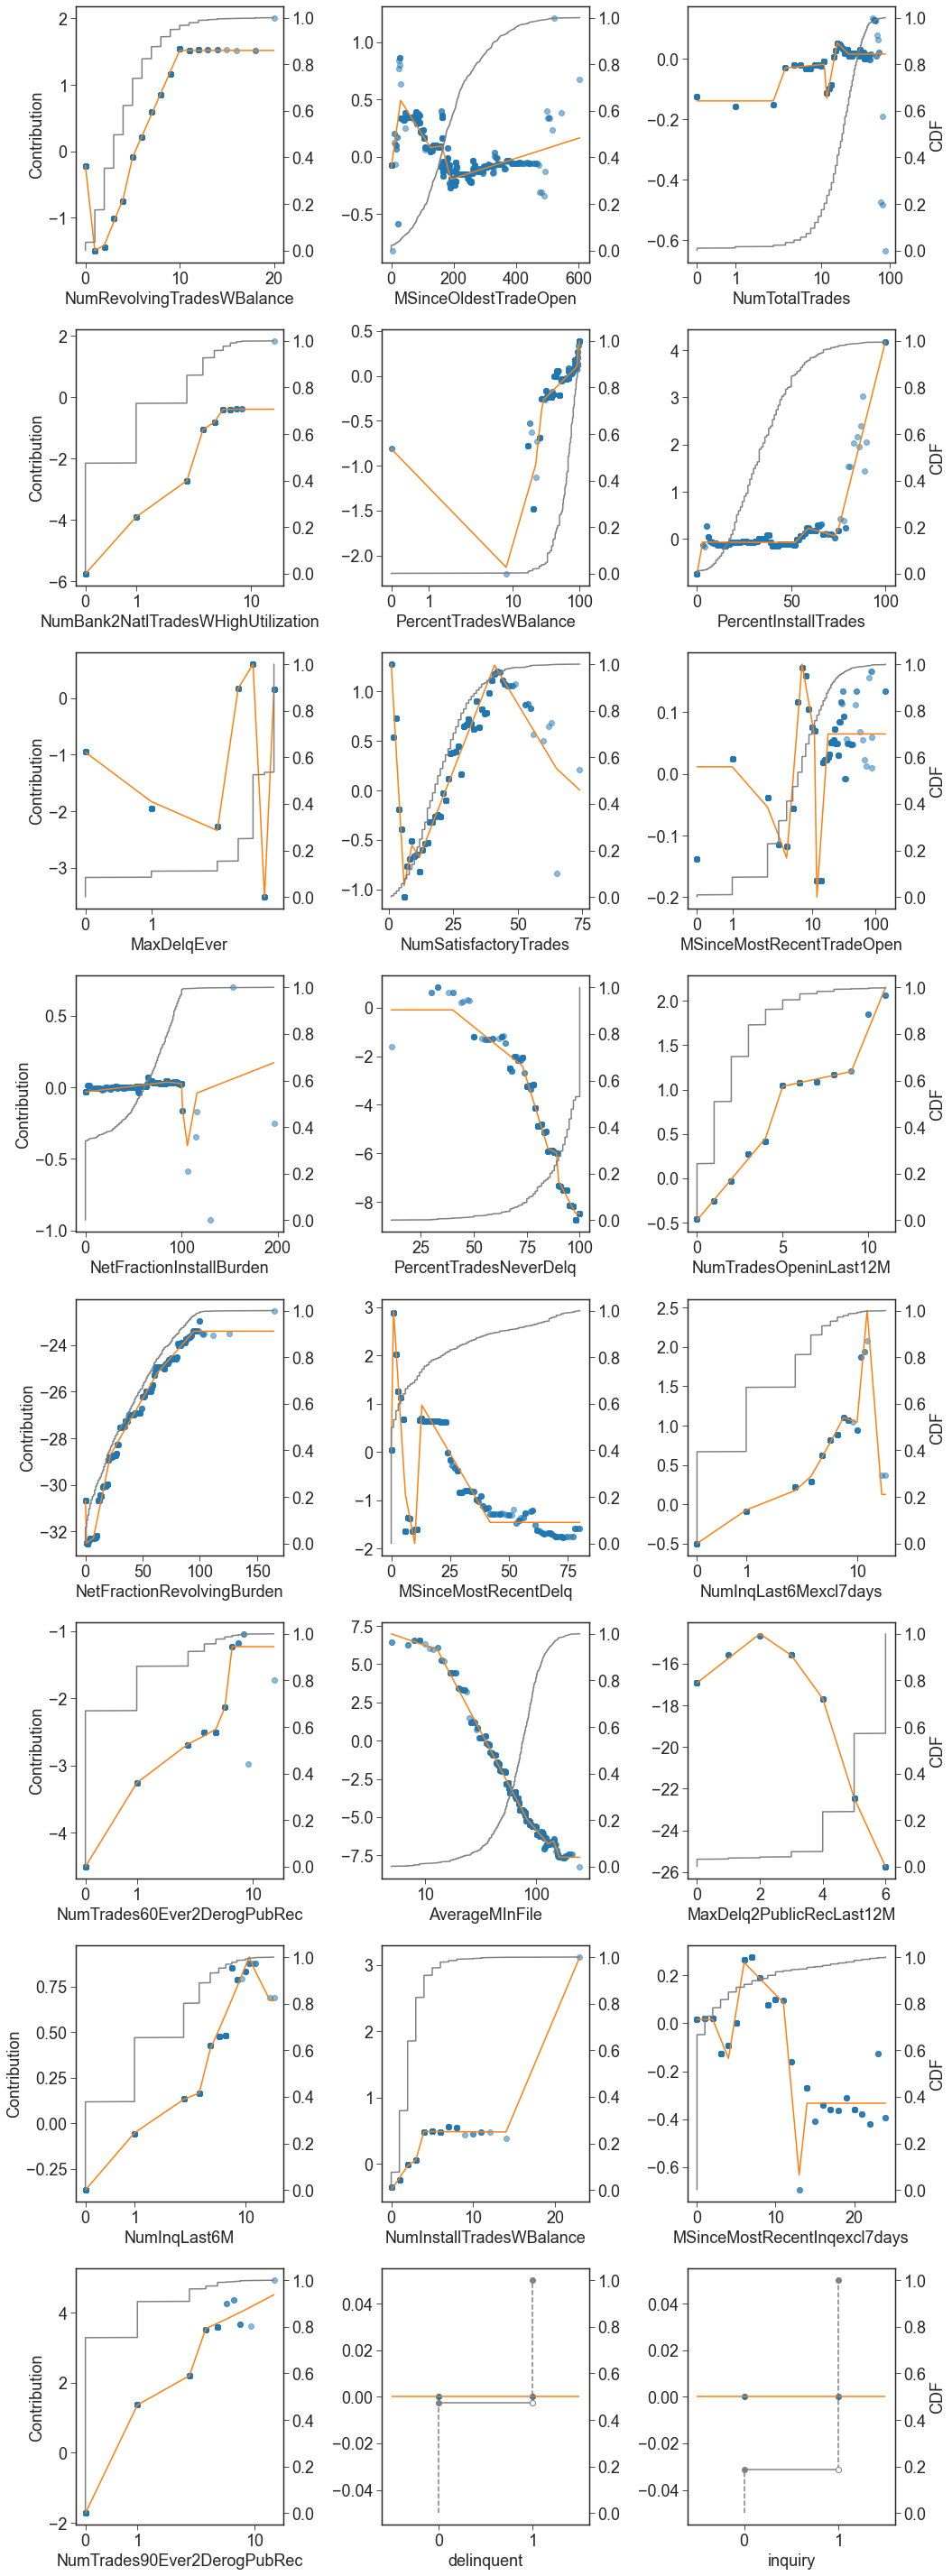

In [13]:
pairs_to_plot = [(model_util.ColumnModel('gam_trees_%s' % name), pwlfit_models[-2].get_submodel(name))
                 for name in CONTINUOUS_FEATURES + CATEGORICAL_FEATURES]
fits_fig = model_util.plot_fits(cv_folds[0], pairs_to_plot)
print(pwlfit_models[-2].name)
fits_fig

pwlfit; num_segments=5 mono=True


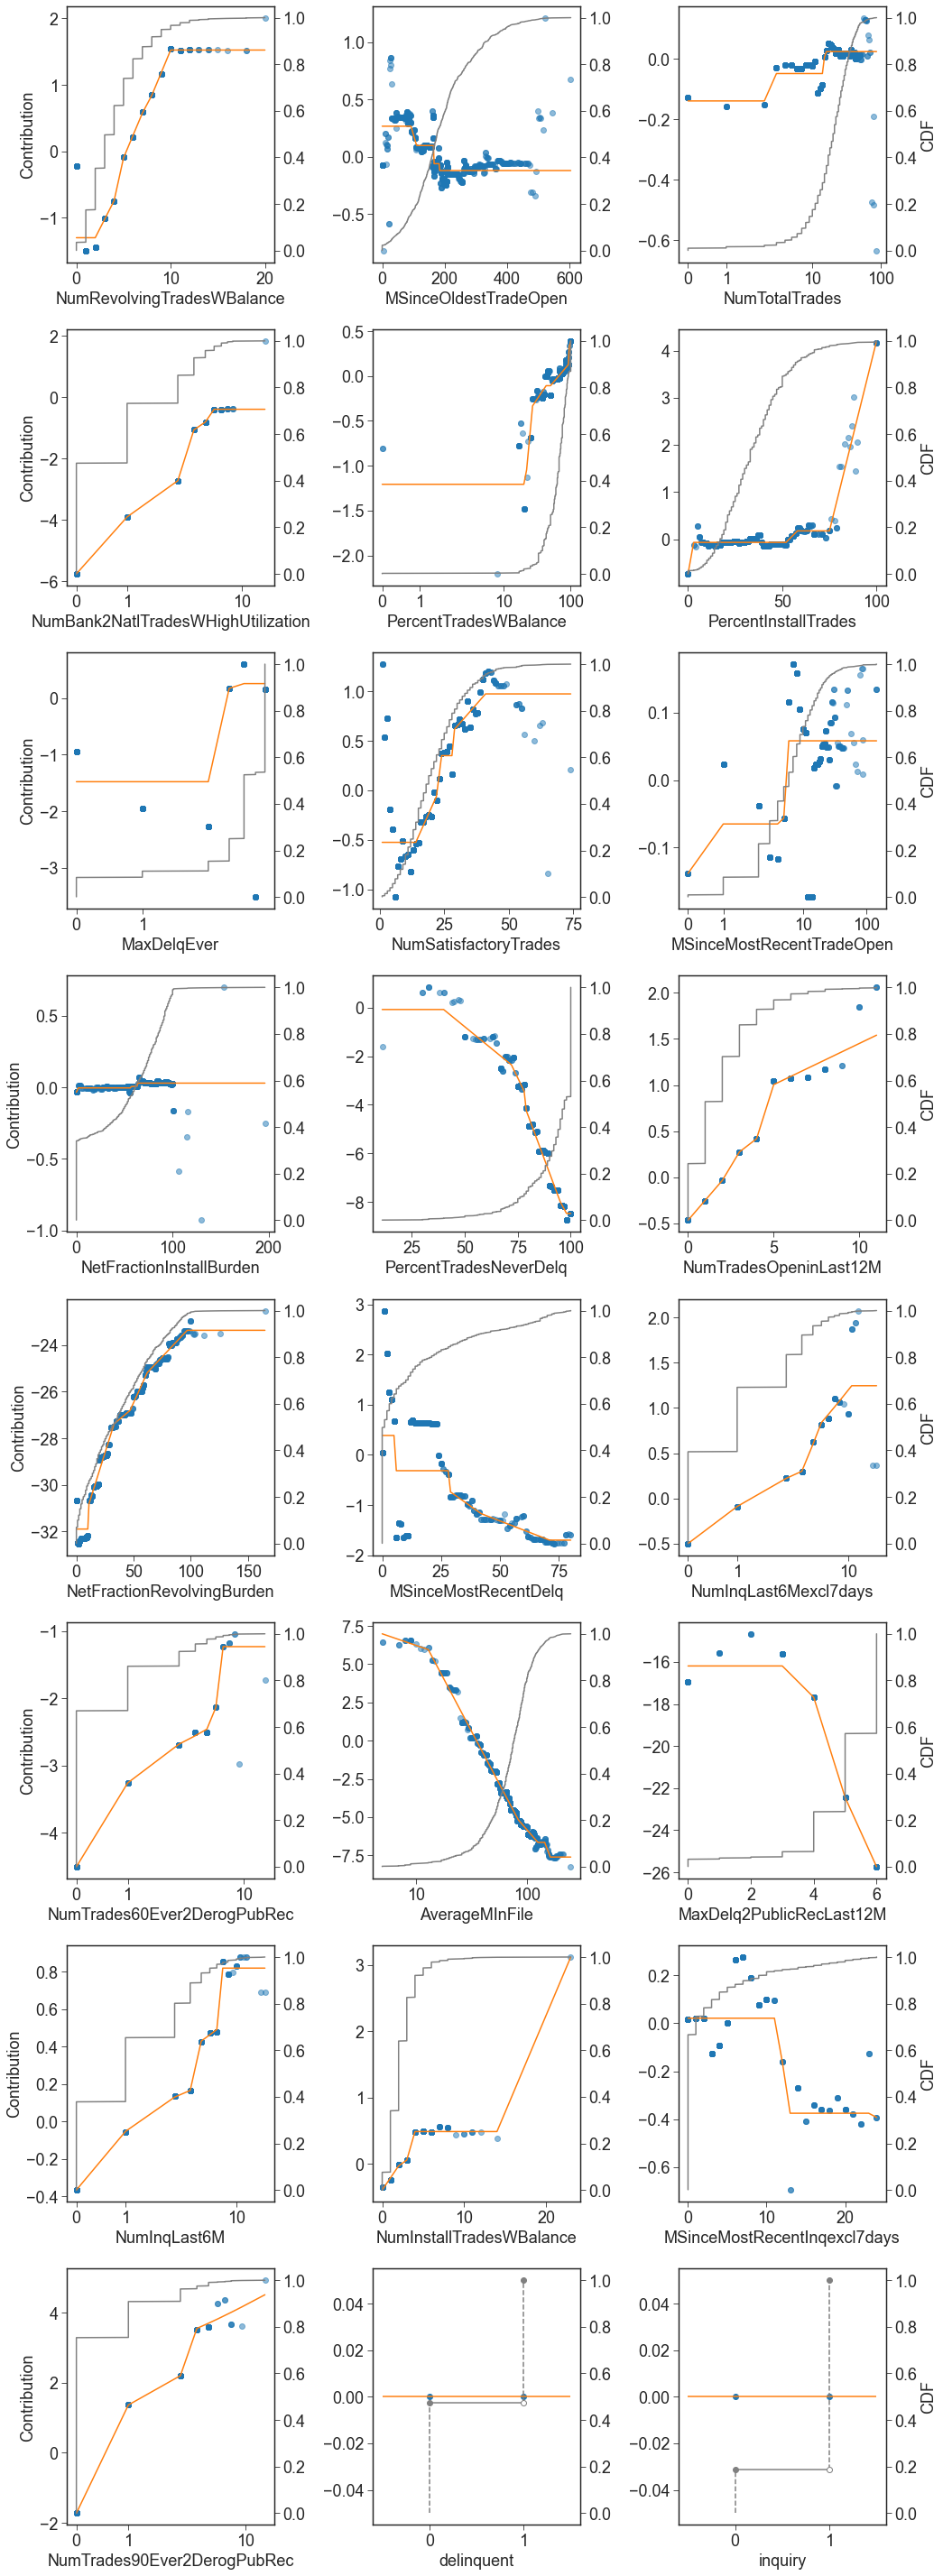

In [14]:
pairs_to_plot = [(model_util.ColumnModel('gam_trees_%s' % name), pwlfit_models[-1].get_submodel(name))
                 for name in CONTINUOUS_FEATURES + CATEGORICAL_FEATURES]
fits_fig = model_util.plot_fits(cv_folds[0], pairs_to_plot)
print(pwlfit_models[-1].name)
fits_fig

pwlfit; num_segments=2 mono=False


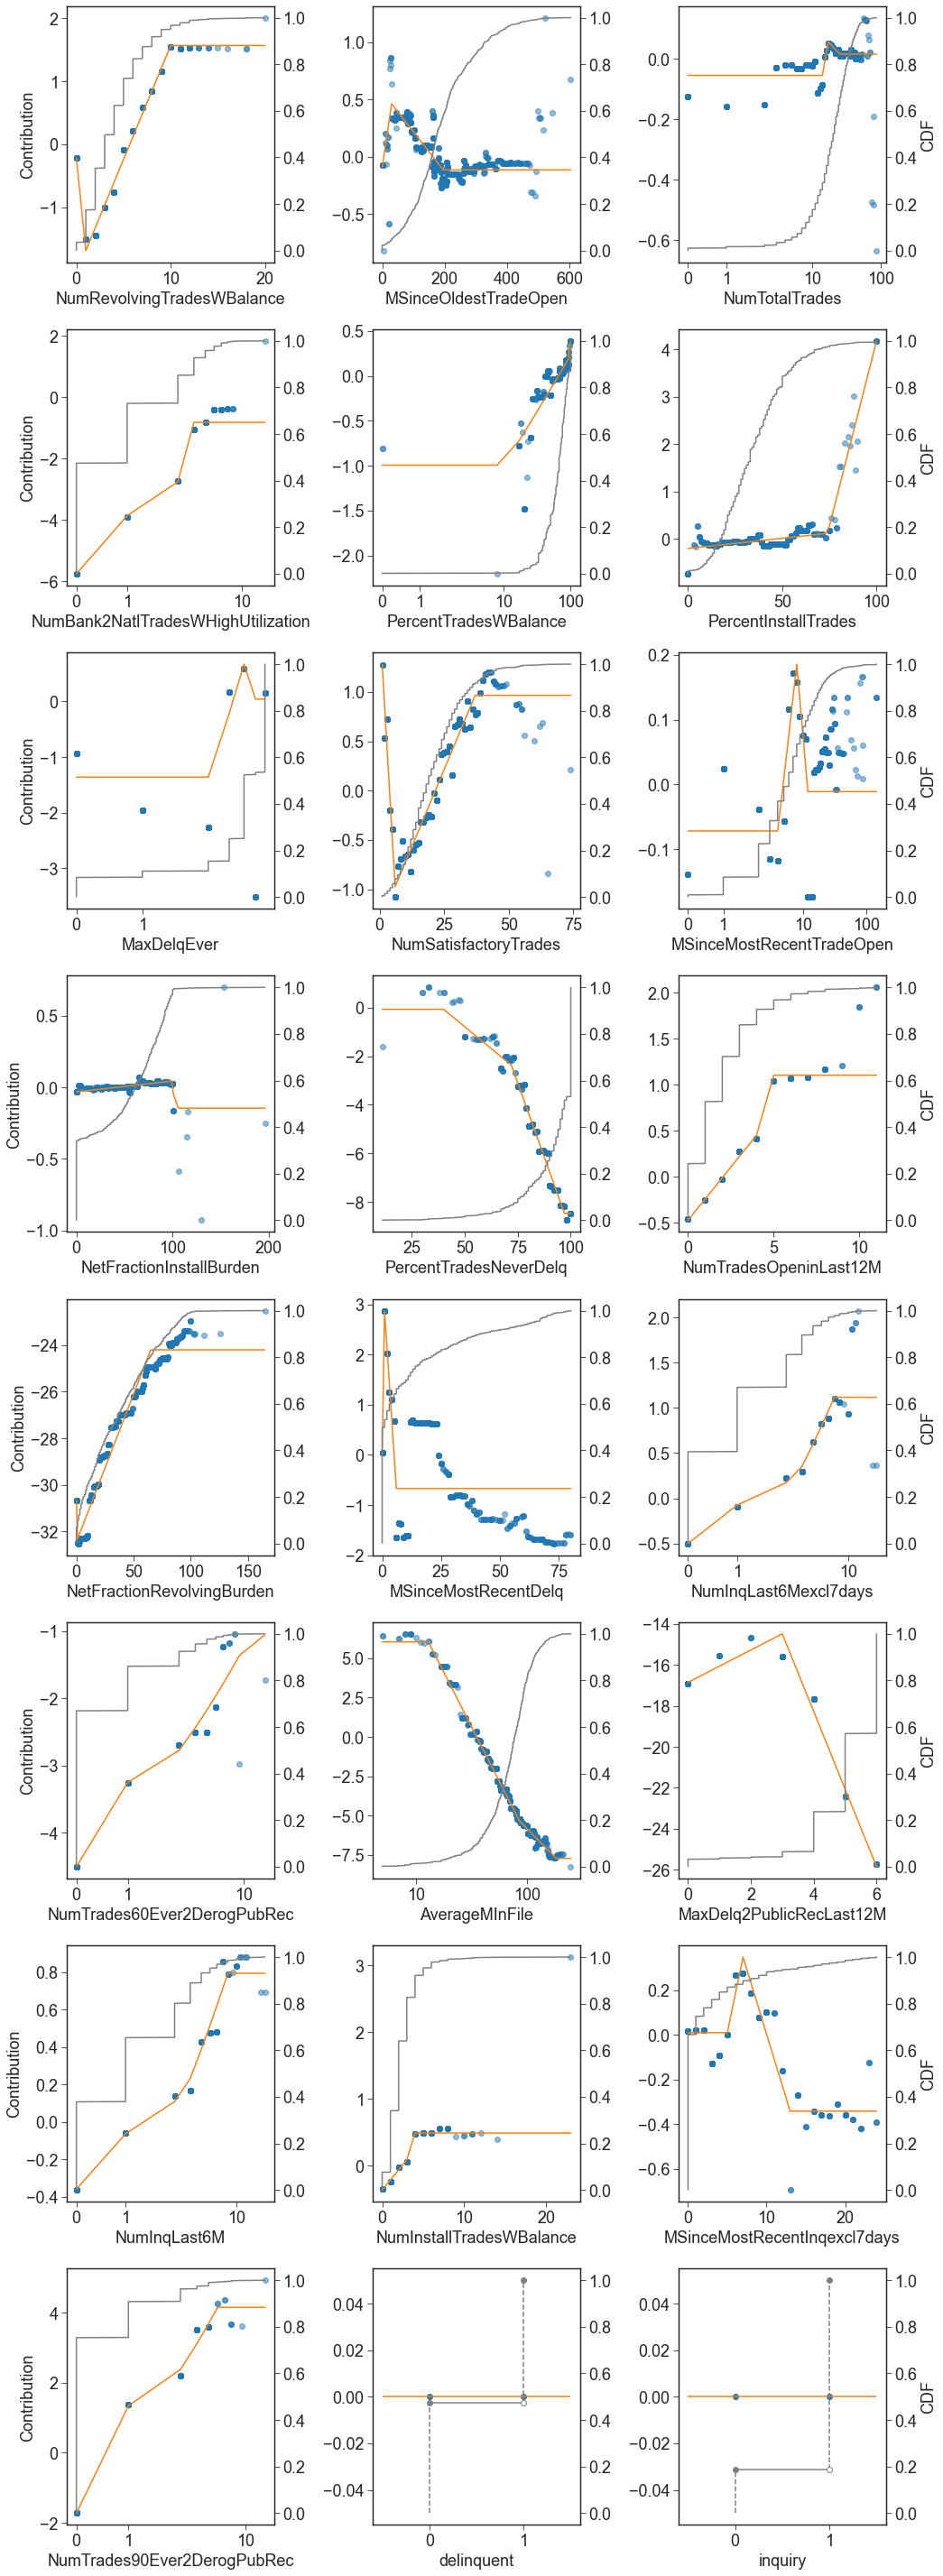

In [15]:
pairs_to_plot = [(model_util.ColumnModel('gam_trees_%s' % name), pwlfit_models[2].get_submodel(name))
                 for name in CONTINUOUS_FEATURES + CATEGORICAL_FEATURES]
fits_fig = model_util.plot_fits(cv_folds[0], pairs_to_plot)
print(pwlfit_models[2].name)
fits_fig